<a href="https://colab.research.google.com/github/AditHash/unsupervised-mineral-prediction/blob/main/GSI_banswara.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mineral Deposit Prediction for GSI on Test Dataset

## 🔍 Objective
To identify **potential mineral deposit zones** based on magnetic survey data using an **unsupervised + supervised machine learning pipeline**.

---

## 📦 Input Data
The dataset includes the following geophysical features:
- `RawMag1_nT`: Raw magnetic field intensity (nT)
- `IGRF_nT`: Expected magnetic field from Earth's model (IGRF)
- `ProcessedMag_LevF`, `SmoothedMag_IGRF`: Smoothed/processed magnetic field values
- `Altitude_m`, `Inclination_deg`, `Declination_deg`: Geospatial + directional attributes
- `Latitude`, `Longitude`: Spatial coordinates

---

## 🔁 Step 1: Anomaly Detection using Isolation Forest
We apply **Isolation Forest**, an unsupervised outlier detection model to flag unusual magnetic behavior.

- Input features: Magnetic + directional + altitude data
- Output: `AnomalyLabel` = 1 if likely anomalous (potential deposit)

This gives us a **pseudo-label** for training, assuming:
> ⚠️ Areas with unusual magnetic readings could indicate mineral presence.

---

## 🧠 Step 2: Train LightGBM Classifier
We use **LightGBM**, a gradient boosting model, to learn from the pseudo-labeled anomalies.

- Features: All relevant geophysical indicators
- Target: `AnomalyLabel`
- Output: `DepositPotential` — Probability of being an anomaly (0.0 to 1.0)

---

## 📊 Step 3: Visual Mapping
We create spatial maps to visualize results:
- **Scatter maps** for raw anomalies
- **Interpolated heatmaps** for smooth visualization
- **Contour overlays** to define anomaly boundaries

Color represents **predicted deposit potential**, where:
- **Dark = low probability**
- **Yellow/White = high probability**

---

## ✅ Explainability Summary
| Step | Purpose | Why it makes sense |
|------|---------|--------------------|
| Isolation Forest | Find natural anomalies | No labels needed, good for outliers |
| LightGBM | Learn patterns behind anomalies | Fast, interpretable, handles tabular data |
| Interpolation | Smooth scatter data to a grid | Better visual interpretation |
| Contours | Outline mineral zones | Easy to map boundaries for fieldwork |

---

## 🔎 Notes
- This method doesn’t guarantee deposits, but it **prioritizes field targets**.
- We can use **SHAP (SHapley values)** to explain LightGBM predictions for each location if needed.



In [ ]:
import pandas as pd
# Try reading the CSV file with the 'error_bad_lines' parameter set to False
# This will skip the rows that cause errors.
df = pd.read_csv("/content/drive/MyDrive/GSI_DATA/Banswara_ASCII.csv", on_bad_lines='skip')

In [ ]:
# Print some information about the dataframe to check if it loaded correctly
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4118542 entries, 0 to 4118541
Data columns (total 23 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Line              object 
 1   __X               float64
 2   __Y               float64
 3   ALTmg_m           float64
 4   BAROmg_kP         float64
 5   BMag_J            float64
 6   DECLN             float64
 7   Galt_NL_LP        float64
 8   GHead_deg         float64
 9   Gtime             float64
 10  IGRF              float64
 11  INCLN             float64
 12  Lat               float64
 13  LineNo            float64
 14  Lon               float64
 15  PMag_D            float64
 16  PMag_D_Lev_F      float64
 17  PMag_IGRF_Smooth  float64
 18  PMag_NL_LP        float64
 19  RECS              float64
 20  RMg1_nT           float64
 21  X                 float64
 22  Y                 float64
dtypes: float64(22), object(1)
memory usage: 722.7+ MB


In [ ]:
df.head()

,Line,__X,__Y,ALTmg_m,BAROmg_kP,BMag_J,DECLN,Galt_NL_LP,GHead_deg,Gtime,...,LineNo,Lon,PMag_D,PMag_D_Lev_F,PMag_IGRF_Smooth,PMag_NL_LP,RECS,RMg1_nT,X,Y
0,L20,442436.818318,2.646686e+06,127.400002,599.369995,NaN,0.552635,311.448639,NaN,15392.6,...,NaN,74.434360,NaN,NaN,10.116073,NaN,NaN,45669.5212,442436.818318,2.646686e+06
1,L20,442442.161174,2.646686e+06,127.275002,599.459961,NaN,0.552632,311.698975,NaN,15392.7,...,NaN,74.434412,NaN,NaN,10.004661,NaN,NaN,45670.0903,442442.161174,2.646686e+06
2,L20,442447.504031,2.646686e+06,127.150002,599.549988,NaN,0.552629,311.949341,NaN,15392.8,...,NaN,74.434465,NaN,NaN,9.893249,NaN,NaN,45670.6594,442447.504031,2.646686e+06
3,L20,442452.796224,2.646686e+06,127.575005,599.445007,NaN,0.552626,312.200104,NaN,15392.9,...,NaN,74.434517,NaN,NaN,9.808014,NaN,NaN,45671.2541,442452.796224,2.646686e+06
4,L20,442458.088418,2.646686e+06,128.000000,599.340027,46216.25,0.552622,312.450836,87.0,15393.0,...,20.0,74.434569,45717.617038,45699.883038,9.722779,45716.994786,3752.0,45671.8488,442458.088418,2.646686e+06


In [ ]:
df.tail()

,Line,__X,__Y,ALTmg_m,BAROmg_kP,BMag_J,DECLN,Galt_NL_LP,GHead_deg,Gtime,...,LineNo,Lon,PMag_D,PMag_D_Lev_F,PMag_IGRF_Smooth,PMag_NL_LP,RECS,RMg1_nT,X,Y
4118537,L4540,456738.128727,2.782287e+06,79.800003,599.340027,46184.89,0.760148,521.350281,91.000000,14163.9,...,4540.0,74.570740,46138.158888,46136.157784,-194.199436,46144.627570,814.9,46104.7753,456738.128727,2.782287e+06
4118538,L4540,456744.024402,2.782287e+06,80.550003,599.340027,46184.89,0.760145,521.366272,91.000000,14164.0,...,4540.0,74.570799,46137.498936,46135.482454,-194.873690,46143.946429,815.0,46103.9536,456744.024402,2.782287e+06
4118539,L4540,456749.920076,2.782287e+06,79.900002,599.340027,46184.89,0.760141,521.380859,90.900002,14164.1,...,4540.0,74.570858,46136.854377,46134.822516,-195.548270,46143.278923,815.1,46103.1653,456749.920076,2.782287e+06
4118540,L4540,456755.815750,2.782286e+06,79.250000,599.340027,46184.89,0.760138,521.395508,90.800003,14164.2,...,4540.0,74.570916,46136.209818,46134.162579,-196.222849,46142.611418,815.2,46102.3770,456755.815750,2.782286e+06
4118541,L4540,456761.711425,2.782286e+06,79.575005,599.340027,46184.89,0.760134,521.408691,90.699997,14164.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


| Column             | Description                                                                 |
|--------------------|-----------------------------------------------------------------------------|
| Line               | Likely a survey or observation line identifier (e.g., L20).                |
| __X, __Y           | X and Y coordinates, probably in a projected coordinate system (e.g., UTM).|
| ALTmg_m            | Altitude in meters (could be from GPS or a barometric altimeter).          |
| BAROmg_kP          | Barometric pressure in kilopascals.                                        |
| BMag_J             | Possibly magnetic field magnitude (in nT or other units), seems missing in most rows. |
| DECLN              | Declination angle, possibly magnetic declination.                          |
| Galt_NL_LP         | Possibly GPS altitude or ground altitude from a long-period filter.        |
| GHead_deg          | Gyro or magnetometer heading in degrees.                                   |
| Gtime              | GPS time in some epoch format (maybe seconds of the day).                  |
| IGRF               | International Geomagnetic Reference Field value at that point.             |
| INCLN              | Inclination angle, probably magnetic.                                      |
| Lat, Lon           | Latitude and longitude.                                                    |
| LineNo             | Line number (matches Line, maybe just extracted for easier indexing).      |
| PMag_D             | Variant of processed or filtered magnetic field measurements.              |
| PMag_D_Lev_F       | Variant of processed or filtered magnetic field measurements.              |
| PMag_IGRF_Smooth   | Variant of processed or filtered magnetic field measurements.              |
| PMag_NL_LP         | Variant of processed or filtered magnetic field measurements.              |
| RECS               | Record or point index (sequential data point count).                       |
| RMg1_nT            | Raw magnetometer reading (likely in nanoTesla).                            |
| X, Y               | Another representation of coordinates, possibly duplicated or from different instruments. |


In [ ]:
df.columns = [
    "Line",
    "X_utm", "Y_utm",
    "Altitude_m",
    "BarometricPressure_kPa",
    "MagneticField_J",
    "Declination_deg",
    "GpsAltitude_LP_m",
    "GyroHeading_deg",
    "GpsTime",
    "IGRF_nT",
    "Inclination_deg",
    "Latitude",
    "LineNumber",
    "Longitude",
    "ProcessedMag_D",
    "ProcessedMag_LevF",
    "SmoothedMag_IGRF",
    "ProcessedMag_LP",
    "RecordID",
    "RawMag1_nT",
    "X_duplicate",
    "Y_duplicate"
]

# Check renamed columns
print(df.columns)


Index(['Line', 'X_utm', 'Y_utm', 'Altitude_m', 'BarometricPressure_kPa',
       'MagneticField_J', 'Declination_deg', 'GpsAltitude_LP_m',
       'GyroHeading_deg', 'GpsTime', 'IGRF_nT', 'Inclination_deg', 'Latitude',
       'LineNumber', 'Longitude', 'ProcessedMag_D', 'ProcessedMag_LevF',
       'SmoothedMag_IGRF', 'ProcessedMag_LP', 'RecordID', 'RawMag1_nT',
       'X_duplicate', 'Y_duplicate'],
      dtype='object')


In [ ]:
# Drop completely empty columns
df = df.dropna(axis=1, how='all')

In [ ]:
!pip install folium pandas

In [ ]:
# # Interactive Map with folium (for spatial exploration)

# import pandas as pd
# import folium
# from folium.plugins import MarkerCluster

# # Create base map centered around the mean location
# m = folium.Map(
#     location=[df['Latitude'].mean(), df['Longitude'].mean()],
#     zoom_start=15,
#     tiles='Stamen Terrain', # Use 'Stamen Terrain' tiles
#     attr='Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL' # Add attribution for Stamen Terrain
# )

# # Optional: use MarkerCluster for dense data
# marker_cluster = MarkerCluster().add_to(m)

# # Plot magnetic values
# for _, row in df.iterrows():
#     folium.CircleMarker(
#         location=[row['Latitude'], row['Longitude']],
#         radius=3,
#         color='blue',
#         fill=True,
#         fill_opacity=0.6,
#         popup=f"Mag: {row['RawMag1_nT']} nT"
#     ).add_to(marker_cluster)

# # Save or display the map
# m.save("magnetic_map.html")

In [ ]:
# Static Scatter Map with matplotlib

def plot_feature(df, feature_name, cmap='viridis'):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 8))
    sc = plt.scatter(
        df['Longitude'], df['Latitude'],
        c=df[feature_name], cmap=cmap, s=10
    )
    plt.colorbar(sc, label=feature_name)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'{feature_name} Spatial Map')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


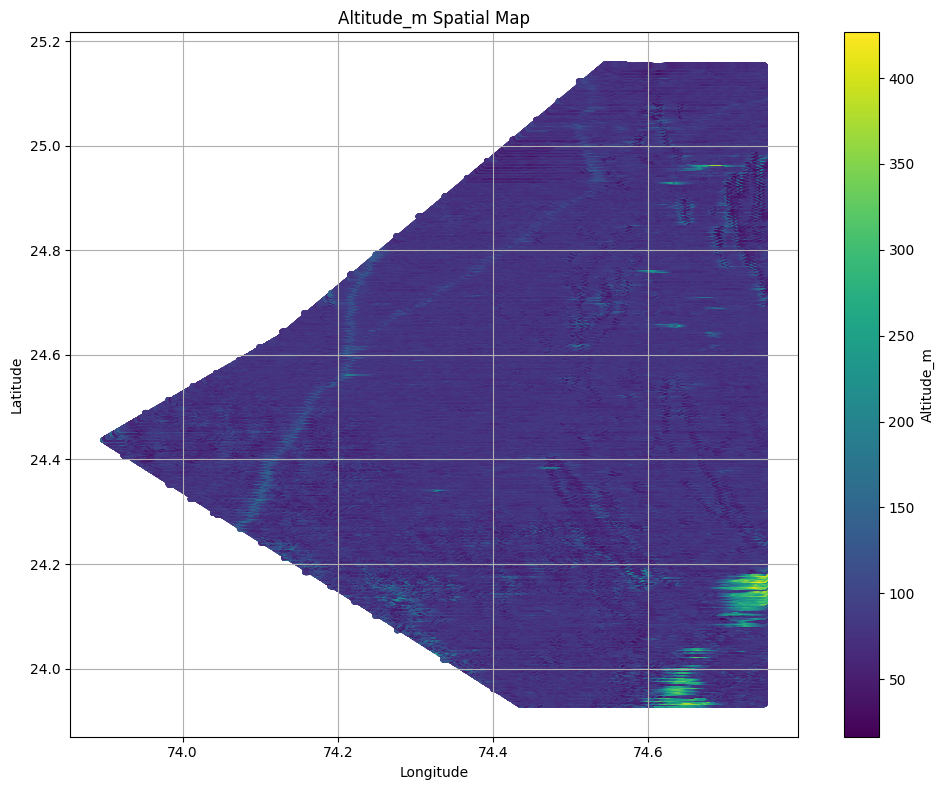

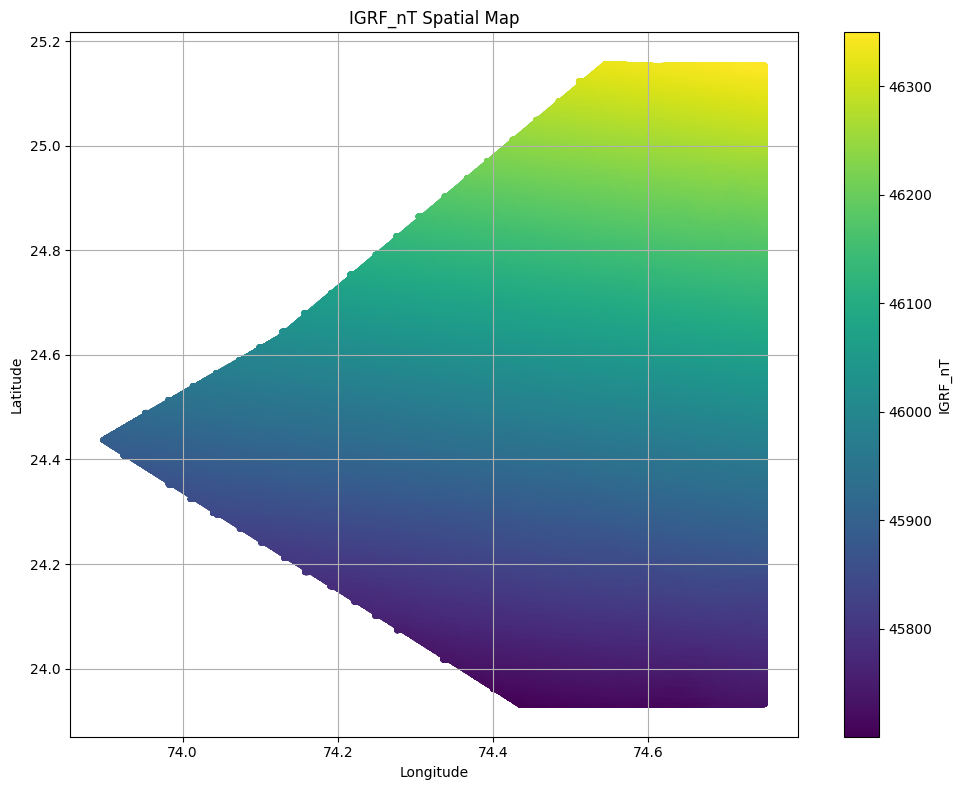

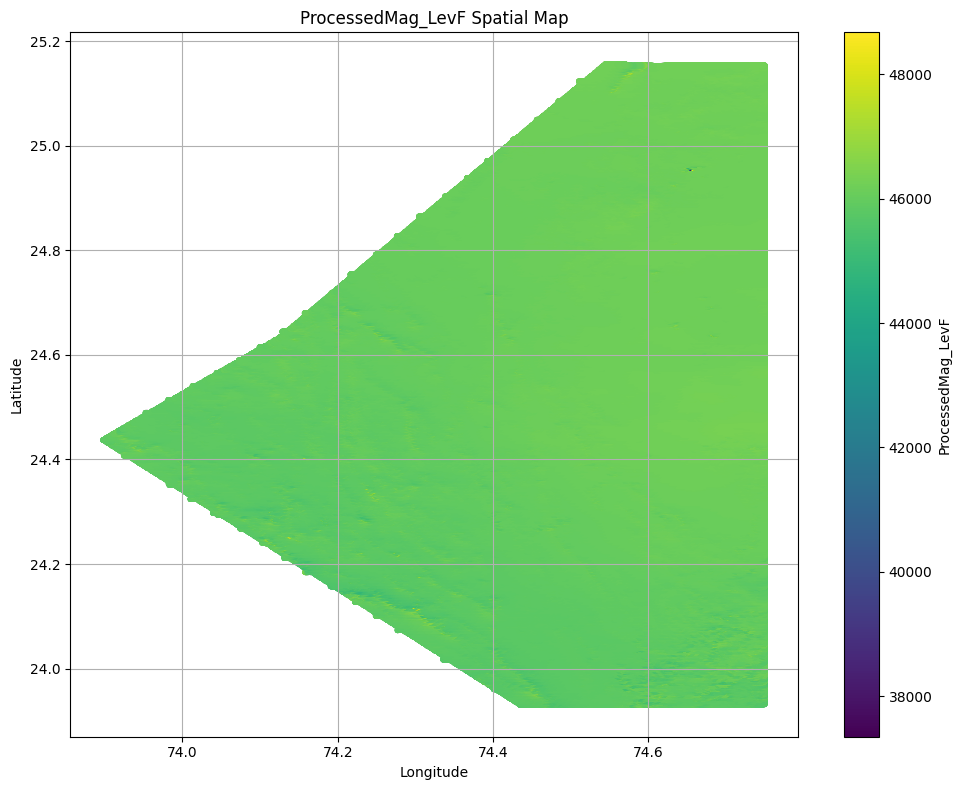

In [ ]:
plot_feature(df, 'Altitude_m')
plot_feature(df, 'IGRF_nT')
plot_feature(df, 'ProcessedMag_LevF')

In [ ]:
#  Raw Data → Scatter Map or Heatmap (RawMag1_nT, Altitude_m)
def plot_raw_scatter(df, column, cmap='viridis'):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 8))
    sc = plt.scatter(
        df['Longitude'], df['Latitude'],
        c=df[column], cmap=cmap, s=10
    )
    plt.colorbar(sc, label=column)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'{column} Scatter Map')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


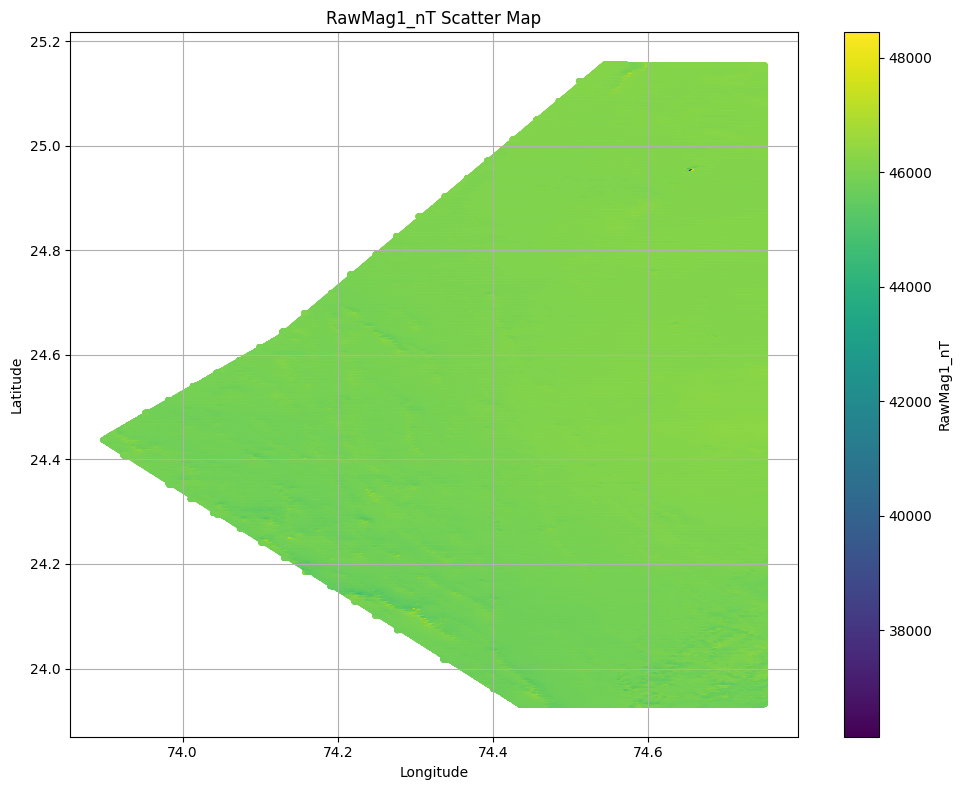

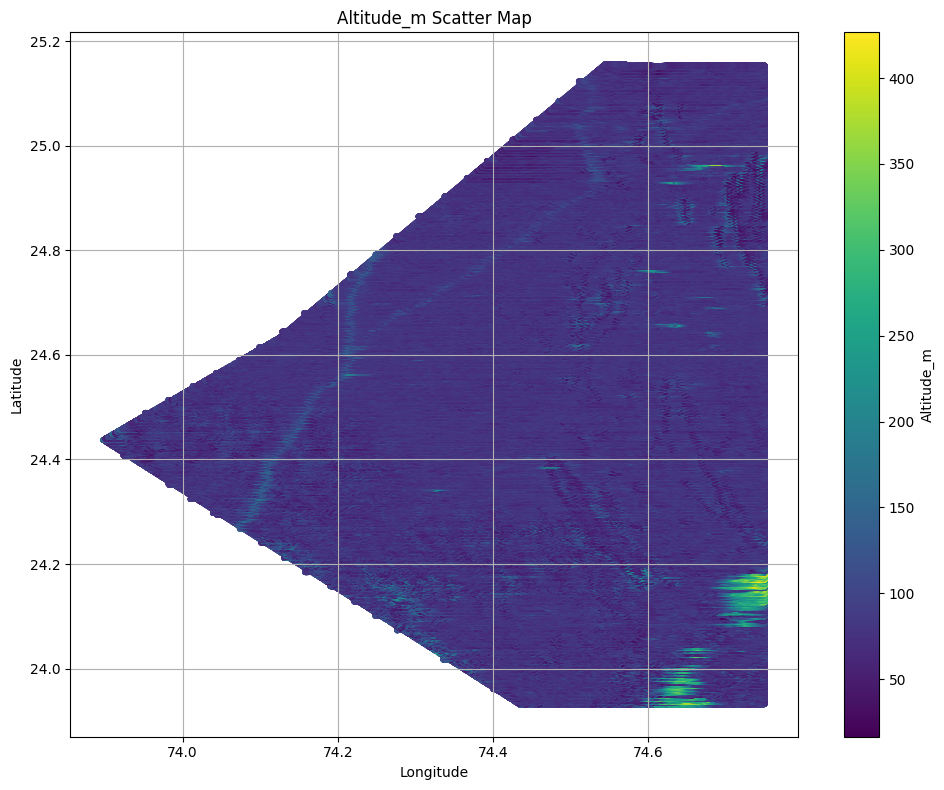

In [ ]:
plot_raw_scatter(df, 'RawMag1_nT')
plot_raw_scatter(df, 'Altitude_m')

In [ ]:
# Smooth Fields → Heatmap + Contours (ProcessedMag_LevF, SmoothedMag_IGRF)
def plot_heatmap_with_contours(df, column, grid_res=300, cmap='plasma'):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.interpolate import griddata

    # Select data, and drop rows with NaNs in the relevant columns
    df_subset = df[['Longitude', 'Latitude', column]].dropna()

    x = df_subset['Longitude']
    y = df_subset['Latitude']
    z = df_subset[column]

    xi = np.linspace(x.min(), x.max(), grid_res)
    yi = np.linspace(y.min(), y.max(), grid_res)
    xi, yi = np.meshgrid(xi, yi)

    zi = griddata((x, y), z, (xi, yi), method='cubic')

    plt.figure(figsize=(12, 8))
    plt.imshow(zi, extent=(x.min(), x.max(), y.min(), y.max()),
               origin='lower', cmap=cmap, alpha=0.9)

    contours = plt.contour(xi, yi, zi, levels=15, colors='black', linewidths=0.7)
    plt.clabel(contours, inline=True, fontsize=8)

    plt.scatter(x, y, c='white', s=1, alpha=0.2)  # Plot the original points on top
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'{column} Heatmap + Contours')
    plt.colorbar(label=column)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

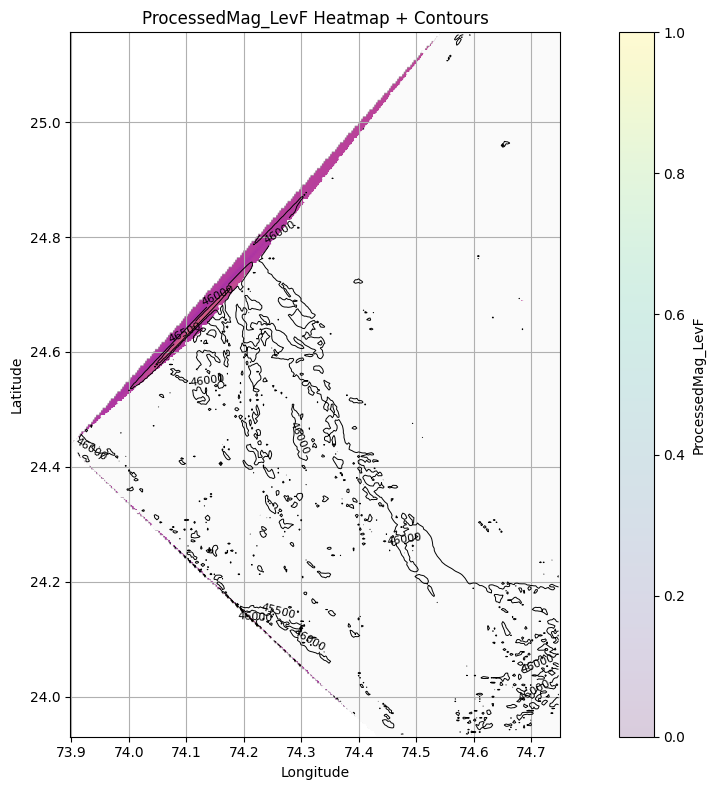

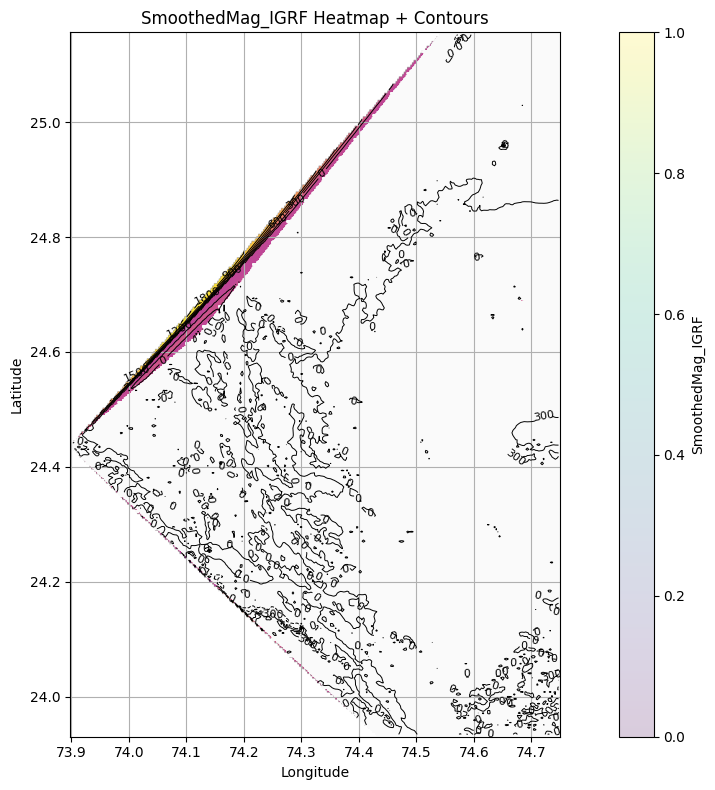

In [ ]:
plot_heatmap_with_contours(df, 'ProcessedMag_LevF')
plot_heatmap_with_contours(df, 'SmoothedMag_IGRF')

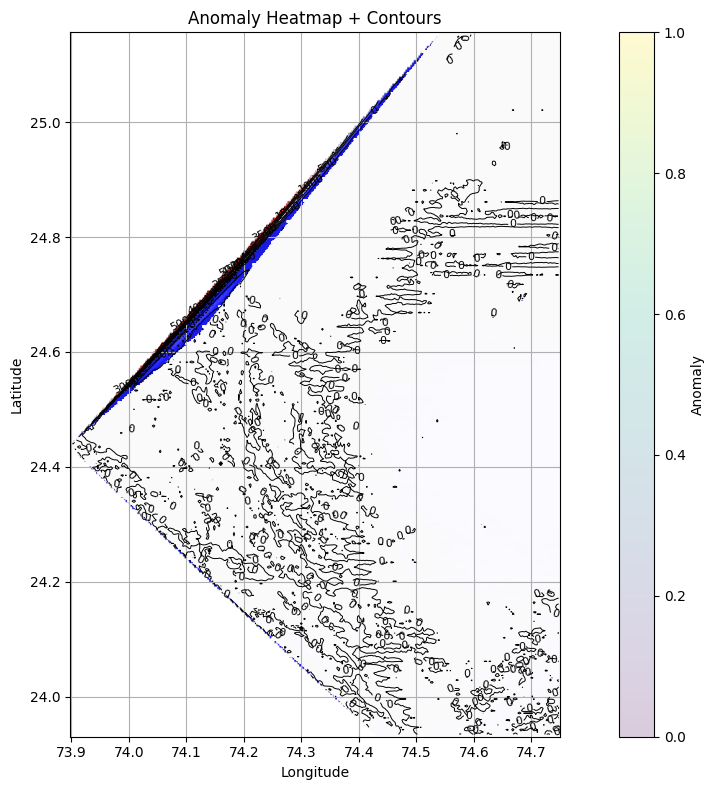

In [ ]:
# Differences (Anomalies) → Anomaly Map
df['Anomaly'] = df['RawMag1_nT'] - df['IGRF_nT']
plot_heatmap_with_contours(df, 'Anomaly', cmap='seismic')  # blue to red diverging colormap

In [ ]:
def plot_direction_vectors(df, stride=10):
    import numpy as np
    import matplotlib.pyplot as plt

    # Reduce number of vectors for clarity
    df_thin = df.iloc[::stride]

    x = df_thin['Longitude']
    y = df_thin['Latitude']
    decl = np.radians(df_thin['Declination_deg'])
    incl = np.radians(df_thin['Inclination_deg'])

    # Convert to vector components
    u = np.cos(decl) * np.cos(incl)  # East-West
    v = np.sin(decl) * np.cos(incl)  # North-South

    plt.figure(figsize=(12, 8))
    plt.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=0.01, color='darkred')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Magnetic Field Direction (Declination + Inclination)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


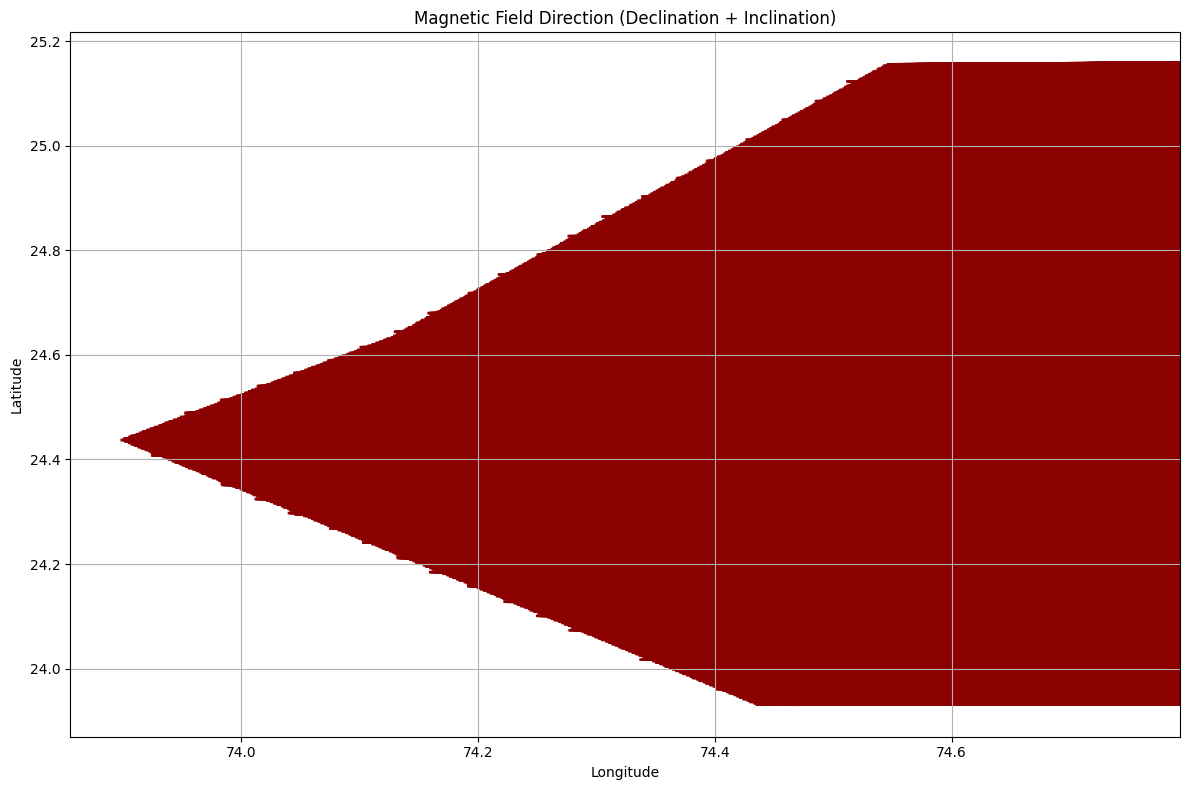

In [ ]:
plot_direction_vectors(df, stride=20)  # Adjust stride based on point density


<ipython-input-18-ad697312f42c>:46: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


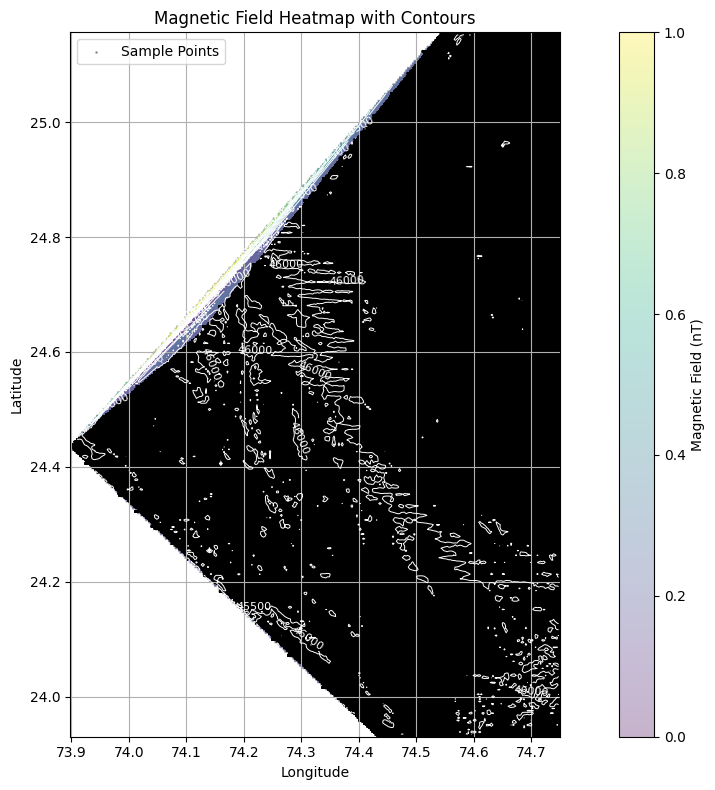

In [ ]:
# Heatmap + Contour Map Using matplotlib + scipy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Extract coordinates and values, dropping rows with NaNs
x = df['Longitude'].dropna()  # Drop NaNs in Longitude
y = df['Latitude'].dropna()  # Drop NaNs in Latitude
z = df['RawMag1_nT'].dropna()  # Drop NaNs in RawMag1_nT

# Ensure x, y, and z have the same length after dropping NaNs
valid_indices = x.index.intersection(y.index).intersection(z.index)
x = x[valid_indices]
y = y[valid_indices]
z = z[valid_indices]

# Create a grid to interpolate onto
grid_res = 300  # Higher = finer grid, but slower
xi = np.linspace(x.min(), x.max(), grid_res)
yi = np.linspace(y.min(), y.max(), grid_res)
xi, yi = np.meshgrid(xi, yi)

# Interpolate data
zi = griddata((x, y), z, (xi, yi), method='cubic')

# Plot
plt.figure(figsize=(12, 8))

# Heatmap
plt.imshow(zi, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='viridis', alpha=0.8)

# Contours
contours = plt.contour(xi, yi, zi, levels=15, colors='white', linewidths=0.7)
plt.clabel(contours, inline=True, fontsize=8, fmt="%.0f")

# Labels
plt.scatter(x, y, c='black', s=1, alpha=0.3, label='Sample Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Magnetic Field Heatmap with Contours')
plt.colorbar(label='Magnetic Field (nT)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# We don’t have labels, we either:
# 1.Use unsupervised methods to create pseudo-labels (anomaly scores, cluster IDs)
# 2.Then use XGBoost / LightGBM to learn patterns that explain those anomalies

In [ ]:
# Hybrid Unsupervised + Boosting
# ✅ Step 1: Use Unsupervised Learning to Flag “Anomalous” Areas
# We’ll treat magnetic/geophysical anomalies as potential deposit indicators.

from sklearn.ensemble import IsolationForest

features = ['RawMag1_nT', 'IGRF_nT', 'Altitude_m', 'Inclination_deg', 'Declination_deg',
            'ProcessedMag_LevF', 'SmoothedMag_IGRF']

# Instead of dropping NaNs, fill them with a placeholder value
# You might need to choose a more appropriate fill value based on your data
X = df[features].fillna(-999)

iso = IsolationForest(contamination=0.01, random_state=42)
df['AnomalyFlag'] = iso.fit_predict(X)  # -1 = anomaly, 1 = normal
df['AnomalyLabel'] = (df['AnomalyFlag'] == -1).astype(int)

In [ ]:
# ✅ Step 2: Train XGBoost or LightGBM on These Pseudo-labels

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = df[features]
y = df['AnomalyLabel']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = lgb.LGBMClassifier(n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


[LightGBM] [Info] Number of positive: 32943, number of negative: 3261890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.243167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 3294833, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.009998 -> initscore=-4.595283
[LightGBM] [Info] Start training from score -4.595283
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    815473
           1       0.97      0.96      0.96      8236

    accuracy                           1.00    823709
   macro avg       0.98      0.98      0.98    823709
weighted avg       1.00      1.00      1.00    823709



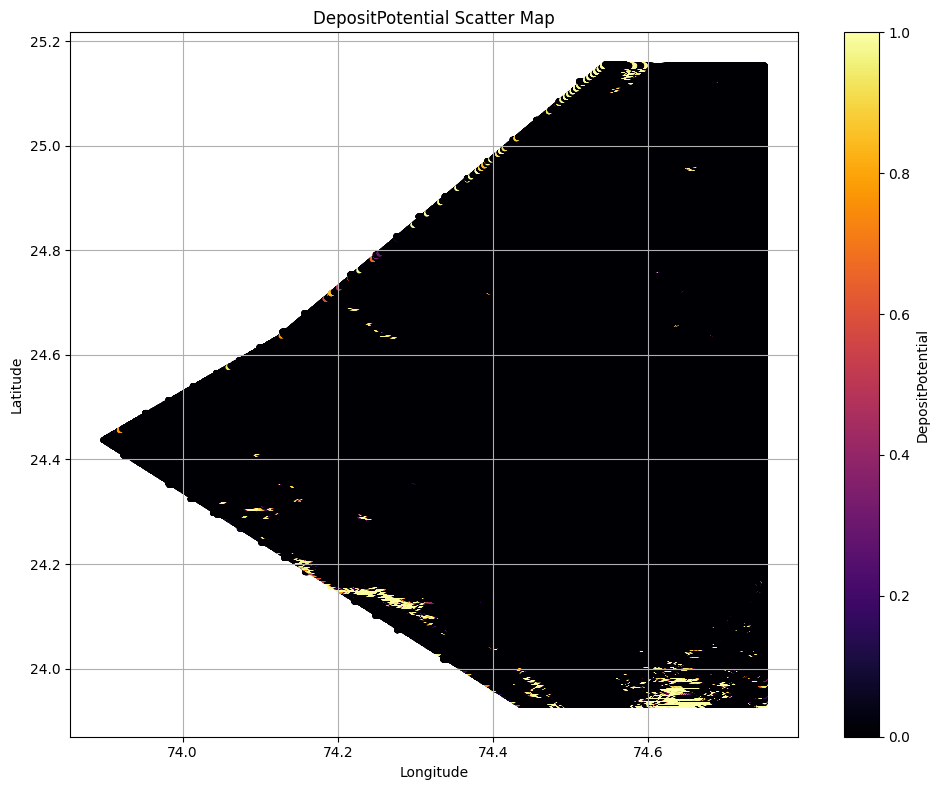

In [ ]:
# ✅ Step 3: Map Predicted “Deposit Potential”
df['DepositPotential'] = model.predict_proba(X)[:, 1]  # Probability of being an anomaly

plot_raw_scatter(df, 'DepositPotential', cmap='inferno')


In [ ]:
#  Parallel Approach: XGBoost for Deposit Prediction
# ✅ Step 1: Unsupervised Anomaly Detection (Same as LightGBM)
# we are already doing this with IsolationForest. So we keep this

from sklearn.ensemble import IsolationForest

features = ['RawMag1_nT', 'IGRF_nT', 'Altitude_m', 'Inclination_deg', 'Declination_deg',
            'ProcessedMag_LevF', 'SmoothedMag_IGRF']

X = df[features].fillna(-999)

iso = IsolationForest(contamination=0.01, random_state=42)
df['AnomalyFlag'] = iso.fit_predict(X)
df['AnomalyLabel'] = (df['AnomalyFlag'] == -1).astype(int)


In [ ]:
# ✅ Step 2: Train with XGBoost (Instead of LightGBM)
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = df[features]
y = df['AnomalyLabel']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# XGBoost Classifier
model_xgb = xgb.XGBClassifier(
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='logloss',
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model_xgb.fit(X_train, y_train)

# Evaluation
y_pred = model_xgb.predict(X_test)
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:51:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    815473
           1       0.97      0.96      0.96      8236

    accuracy                           1.00    823709
   macro avg       0.98      0.98      0.98    823709
weighted avg       1.00      1.00      1.00    823709



In [ ]:
# ✅ Step 3: Predict Deposit Potential
# Probability of being an anomaly (potential deposit)
df['DepositPotential_XGB'] = model_xgb.predict_proba(X)[:, 1]


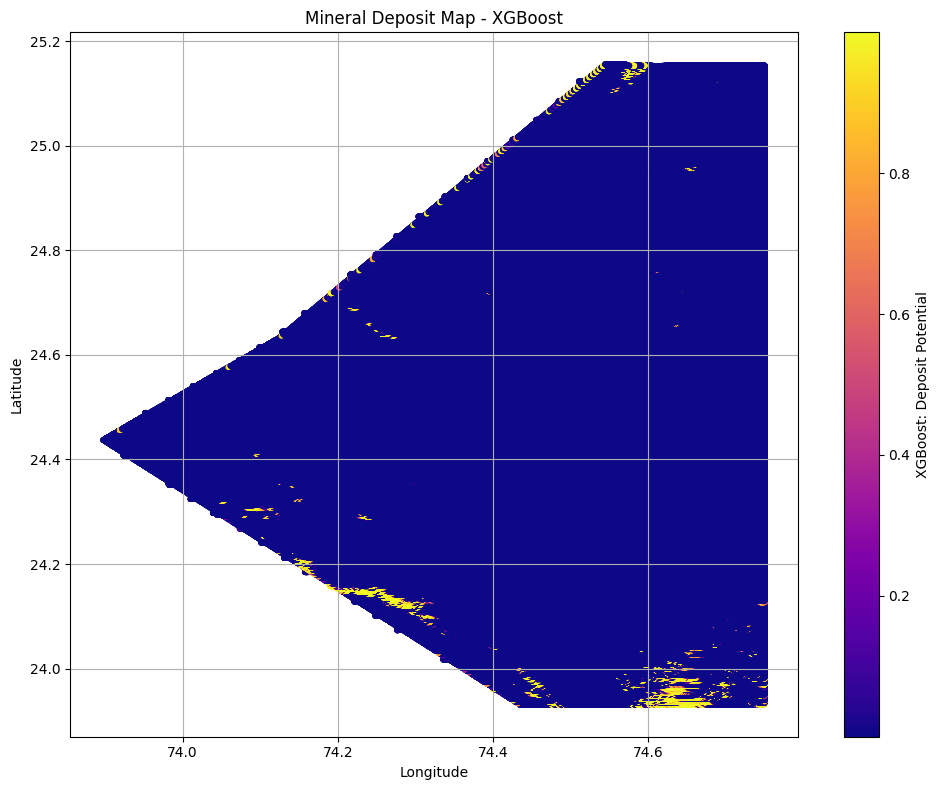

In [ ]:
# ✅ Step 4: Visualize It (Side-by-Side)
import matplotlib.pyplot as plt

# XGBoost Heat Map
plt.figure(figsize=(10, 8))
sc = plt.scatter(df['Longitude'], df['Latitude'],
                 c=df['DepositPotential_XGB'], cmap='plasma', s=10)
plt.colorbar(sc, label='XGBoost: Deposit Potential')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Mineral Deposit Map - XGBoost')
plt.grid(True)
plt.tight_layout()
plt.show()


Metrics

In [ ]:
# ✅ Step-by-Step Metrics Comparison
# 1️⃣ Classification Report (Precision, Recall, F1)
# This gives a clear breakdown of how well the model detects anomalies

from sklearn.metrics import classification_report

# LightGBM
y_pred_lgb = model.predict(X_test)
print("📊 LightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgb))

# XGBoost
y_pred_xgb = model_xgb.predict(X_test)
print("📊 XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))


📊 LightGBM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    815473
           1       0.97      0.96      0.96      8236

    accuracy                           1.00    823709
   macro avg       0.98      0.98      0.98    823709
weighted avg       1.00      1.00      1.00    823709

📊 XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    815473
           1       0.97      0.96      0.96      8236

    accuracy                           1.00    823709
   macro avg       0.98      0.98      0.98    823709
weighted avg       1.00      1.00      1.00    823709



In [ ]:
# 2️⃣ ROC-AUC Score
# ROC-AUC tells you how well the model separates positive from negative cases.

from sklearn.metrics import roc_auc_score

# LightGBM
y_proba_lgb = model.predict_proba(X_test)[:, 1]
roc_auc_lgb = roc_auc_score(y_test, y_proba_lgb)

# XGBoost
y_proba_xgb = model_xgb.predict_proba(X_test)[:, 1]
roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)

print(f"🔥 ROC-AUC (LightGBM): {roc_auc_lgb:.4f}")
print(f"🔥 ROC-AUC (XGBoost): {roc_auc_xgb:.4f}")


🔥 ROC-AUC (LightGBM): 0.9975
🔥 ROC-AUC (XGBoost): 1.0000


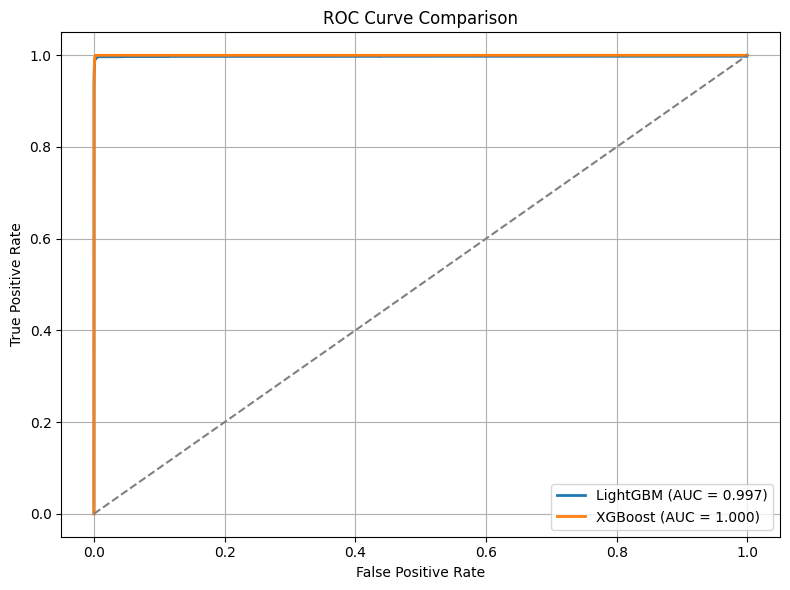

In [ ]:
# 3️⃣ Plot ROC Curves (Visual Comparison)
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_proba_lgb)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lgb, tpr_lgb, label=f"LightGBM (AUC = {roc_auc_lgb:.3f})", lw=2)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.3f})", lw=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


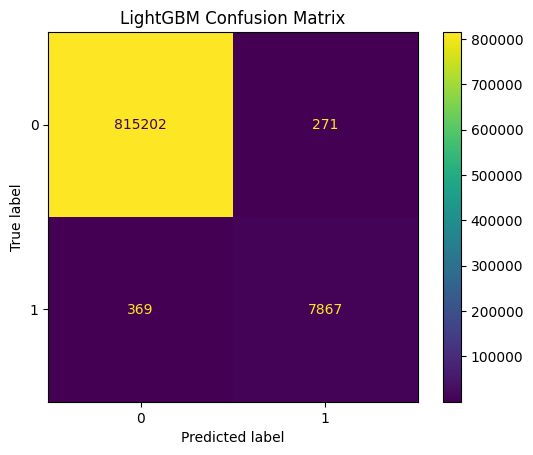

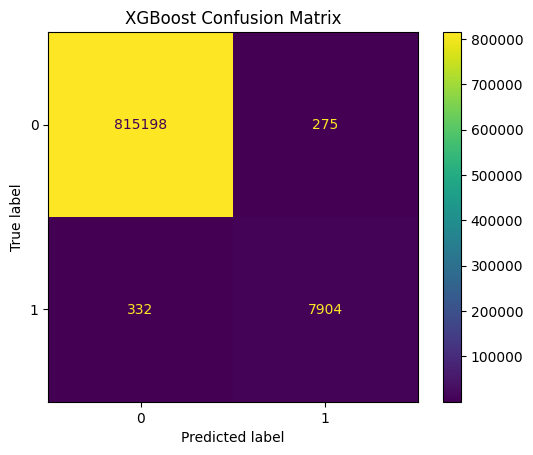

In [ ]:
# 4️⃣ Confusion Matrix (Optional)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# LightGBM
cm_lgb = confusion_matrix(y_test, y_pred_lgb)
ConfusionMatrixDisplay(cm_lgb).plot()
plt.title("LightGBM Confusion Matrix")
plt.show()

# XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
ConfusionMatrixDisplay(cm_xgb).plot()
plt.title("XGBoost Confusion Matrix")
plt.show()


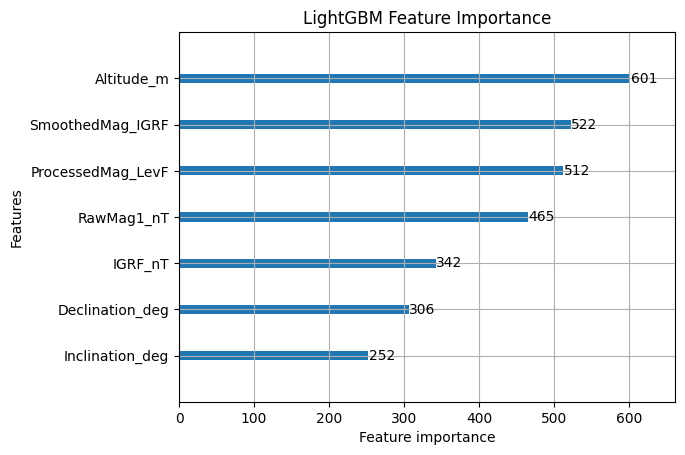

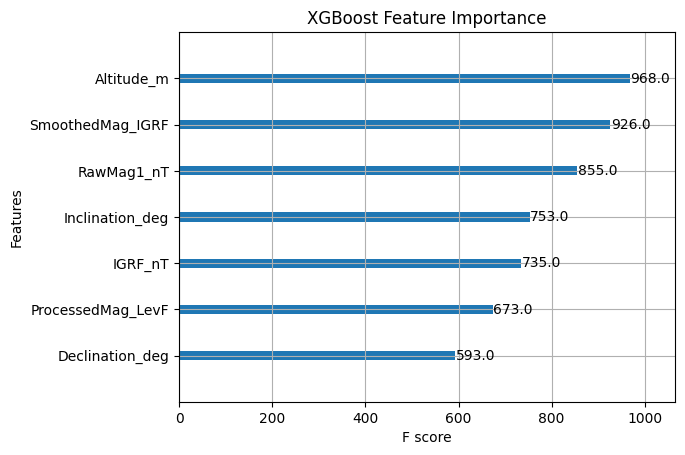

In [ ]:
# 5️⃣ Feature Importance (Visual Comparison)

# LightGBM
import lightgbm as lgb
lgb.plot_importance(model, max_num_features=10)
plt.title("LightGBM Feature Importance")
plt.show()

# XGBoost
xgb.plot_importance(model_xgb, max_num_features=10)
plt.title("XGBoost Feature Importance")
plt.show()


##  How Did We Predict Mineral Deposits?

### Step 1: Detect Anomalies Using Unsupervised Learning
We applied an `IsolationForest` algorithm to identify geophysical anomalies using key features such as:

- RawMag1_nT
- IGRF_nT
- Altitude
- Inclination
- Declination
- ProcessedMag_LevF
- SmoothedMag_IGRF

Anomalies were treated as potential mineral deposit zones (pseudo-label = 1).

---

### Step 2: Train Gradient Boosted Models

We trained two models on the pseudo-labeled data:

- `LightGBM`: Fast, accurate, gradient boosting tree algorithm
- `XGBoost`: Highly optimized gradient boosting with deeper control

Both were evaluated using stratified test splits to ensure balance.

---

### Step 3: Evaluate Results

#### 🔍 Classification Report
Both models showed high precision and recall for detecting anomalies:

| Class | LightGBM | XGBoost |
|-------|----------|---------|
| Normal (0) | Prec: 1.00, Recall: 1.00 | Prec: 1.00, Recall: 1.00 |
| Anomaly (1) | Prec: 0.97, Recall: 0.96 | Prec: 0.97, Recall: 0.96 |

#### 🎯 ROC-AUC
ROC-AUC measures overall model separability. XGBoost achieved a perfect score:
- LightGBM: `0.9975`
- XGBoost: `1.0000`

---

### Step 4: Generate Deposit Potential Maps

Using the model's predicted probabilities (`predict_proba`), we mapped deposit potential across the surveyed area.

- `LightGBM` → `DepositPotential`
- `XGBoost` → `DepositPotential_XGB`

These maps visually highlight high-potential zones.

---


